Le dataset étudié provient de kaggle (https://www.kaggle.com/datasets/alexandrakim2201/spotify-dataset).<br> Il contient une  colonne Review avec comme élément des commentaires d'utilisateurs de Spotify et une colonne précisant s'il s'agit d'un commentaire positif ou négatif. <br>
Dans un premier, temps on nettoyera les données pour établir un modèle de prédiction. Enfin, on utilisera ce modèle pour expliquer ou comprendre les points forts/faibles de Spotify.

# Importation des Bibliothèques

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
import string
import pandas as pd
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Découverte du jeu de données

In [4]:
data=pd.read_csv("spotify_data.csv")

In [5]:
print(data.shape)
data.head()

(37483, 2)


,Review,label
0,"Great music service, the audio is high quality...",POSITIVE
1,Please ignore previous negative rating. This a...,POSITIVE
2,"This pop-up ""Get the best Spotify experience o...",NEGATIVE
3,Really buggy and terrible to use as of recently,NEGATIVE
4,Dear Spotify why do I get songs that I didn't ...,NEGATIVE


In [6]:
data.isna().sum()

,0
Review,0
label,1


On enlève les colonnes où il n'y a pas de review

In [7]:
df=data.dropna(axis=0)
df.shape

(37482, 2)

<Axes: xlabel='label', ylabel='count'>

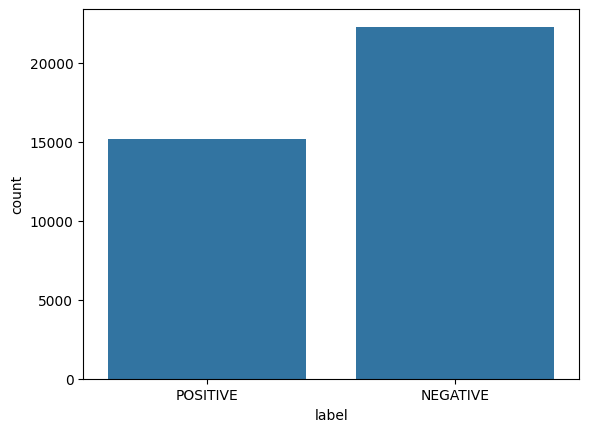

In [8]:
sns.countplot(x='label', data=data)

Il n'y a pas de différence flagrante. Le jeu de données n'est pas biaisé sur cet aspect.

# Nettoyage des textes

In [9]:
def clean_text(text):
    text=text.lower()
    text=text.strip()
    return text.translate(str.maketrans('', '', string.punctuation+'0123456789')) # On supprime les chiffres et la ponctuation

df.loc[:, 'Review'] = df.Review.apply(clean_text)

# Tokenization et Stop Words

In [10]:
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize

def tokenize_text(text):
    text=text.lower().strip()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

df.loc[:, "tokenize"] = df.Review.apply(tokenize_text)


<ipython-input-10-2ee245ac29d1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "tokenize"] = df.Review.apply(tokenize_text)


# Lemmatization

In [11]:
from nltk.stem import WordNetLemmatizer

def lemmatization(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

df.loc[:, "lemmatize"] = df.tokenize.apply(lemmatization)


<ipython-input-11-25191de8c840>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "lemmatize"] = df.tokenize.apply(lemmatization)


# Filtration des mots

On va regarder si certains mots liés au vocabulaire de Spotify (ou d'autres mots jugés inutiles) n'apparaissent pas trop pour les supprimer. <br>Aussi, on va supprimer les mots apparaissant moins de x fois (en déterminant x).

In [12]:
# Compter la fréquence des mots dans tout le dataset
from collections import Counter

tous_les_mots = [mot for sous_liste in df['lemmatize'] for mot in sous_liste]
compteur = Counter(tous_les_mots)

On va visualiser les 20 mots les plus fréquents dans le dataset:

In [13]:
compteur.most_common()[:20]

[('app', 21370),
 ('song', 19380),
 ('music', 15465),
 ('spotify', 10544),
 ('play', 8339),
 ('playlist', 6041),
 ('like', 5738),
 ('ad', 5667),
 ('love', 5471),
 ('good', 5261),
 ('listen', 5238),
 ('cant', 5214),
 ('premium', 4912),
 ('great', 4425),
 ('playing', 4135),
 ('time', 3969),
 ('even', 3962),
 ('dont', 3955),
 ('update', 3790),
 ('im', 3728)]

Je décide de supprimer les mots jugés inutiles qui sont trop communs:

In [14]:
words_to_remove={"app","song","spotify","music","play","get","playing","use","listen","playlist"}
stop_words.update(words_to_remove)
def remove_stopwords(tokens):
    return  [str(mot) for mot in tokens if mot not in stop_words]

df.loc[:, "lemmatize"] = df.lemmatize.apply(remove_stopwords)

# Visualisation de la fréquence des mots

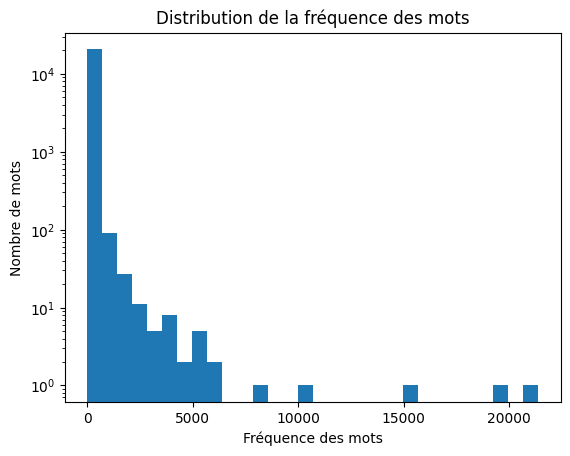

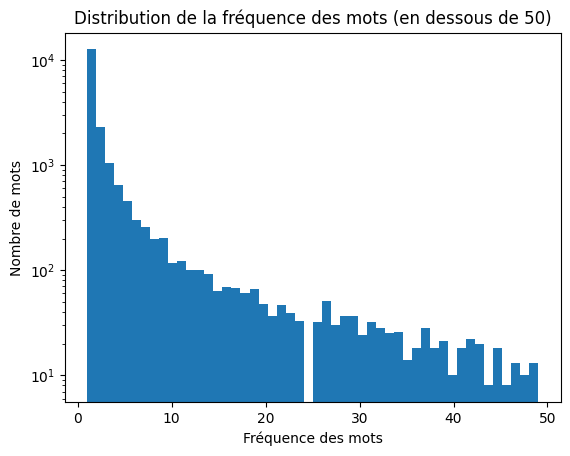

In [15]:
import matplotlib.pyplot as plt

frequencies = list(compteur.values())

plt.hist(frequencies, bins=30, log=True)
plt.xlabel('Fréquence des mots')
plt.ylabel('Nombre de mots')
plt.title('Distribution de la fréquence des mots')
plt.show()
frequencies = list(compteur.values())

less_than_50 =[i for i in frequencies if i<50]
plt.hist(less_than_50, bins=50,log=True)
plt.xlabel('Fréquence des mots')
plt.ylabel('Nombre de mots')
plt.title('Distribution de la fréquence des mots (en dessous de 50)')
plt.show()


On remarque qu'il y a énormément de mots avec une fréquence en dessous de 50. Supprimer les mots avec une fréquence en dessous d'un certain seuil pourrait grandement réduire la dimensionnalité de notre dataset.<br> On va visualiser le pourcentage de mots conservé si on supprime tous les mots avec une fréquence en dessous d'un seuil donné:

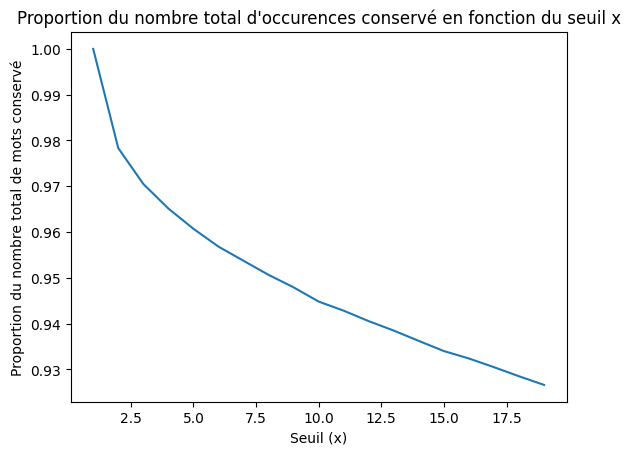

In [16]:
total_words = sum(frequencies)
coverage = []

for threshold in range(1, 20):
    filtered_words = [freq for freq in frequencies if freq >= threshold]
    coverage.append(sum(filtered_words) / total_words)

plt.plot(range(1, 20), coverage)
plt.xlabel('Seuil (x)')
plt.ylabel("Proportion du nombre total de mots conservé")
plt.title("Proportion du nombre total d'occurences conservé en fonction du seuil x")
plt.show()


On remarque que l'on conserve environ 96.5% de la proportion du nombre total d'occurences en prenant x=5

In [17]:
# Voir le nombre de mots qui apparaissent moins de 5 fois
less_than_5 = [item[0] for item in compteur.items() if item[1] < 6]
more_than_5=[item[0] for item in compteur.items() if item[1] >= 6]
len(less_than_5)

17021

Enlever ces mots réduira considérablement la dimension de notre dataset sans réellement affecter (négativement) les performances de nos modèles. Cela pourra éventuellement les rendre plus performants.

# Vectorisation

On doit changer le format de la colonne pour la fonction de vectorisation

In [18]:
def delete_less_than_5(text):
    text_return=[]
    for word in text:
        if word in more_than_5:
            text_return.append(word)
    return text_return
df.loc[:,"filtered"]=df["lemmatize"].apply(delete_less_than_5)

<ipython-input-18-7c9d95bf968b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"filtered"]=df["lemmatize"].apply(delete_less_than_5)


In [19]:
df.loc[:,'lemmatize_j'] = df['lemmatize'].apply(lambda x: ' '.join(x))

<ipython-input-19-27f9fe548e7a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'lemmatize_j'] = df['lemmatize'].apply(lambda x: ' '.join(x))


On utilise la méthode TF-IDF pour vectoriser nos mots. On ne sélectionne pas les mots avec une fréquence inférieure à 10. Cela aura pour but de réduire la dimension de la vectorisation et d'éventuellement le bruit associé.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(min_df=6)
X=tfidf_vect.fit_transform(df['lemmatize_j'])

On regarde de combien on a réduit la dimension:

In [21]:
len(less_than_5)-X.shape[1]

13474

# Modèles

Le jeu de données est très grand. De ce fait on se contente ici de tester les modèles sans nécessairement optimiser les hyperparamètres par cross-validation. <br>Comme on a un nombre assez proche de review positives et négatives, on va utiliser l'accuracy pour comparer les modèles entre eux, sans non plus utiliser de graphique ROC.

In [22]:
Y=df["label"].apply(lambda x: 1 if x=="POSITIVE" else 0)

from sklearn.model_selection import KFold,cross_val_score
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
from sklearn.linear_model import LogisticRegression

scores_lr = cross_val_score(LogisticRegression(), X, Y, cv=kf)

In [24]:
from sklearn.naive_bayes import MultinomialNB
scores_mnb= cross_val_score(MultinomialNB(), X, Y, cv=kf)

In [25]:
from sklearn.svm import SVC

scores_svm= cross_val_score(SVC(kernel="linear"), X, Y, cv=kf)

In [26]:
from sklearn.ensemble import RandomForestClassifier
scores_rfc= cross_val_score(RandomForestClassifier(), X, Y, cv=kf)

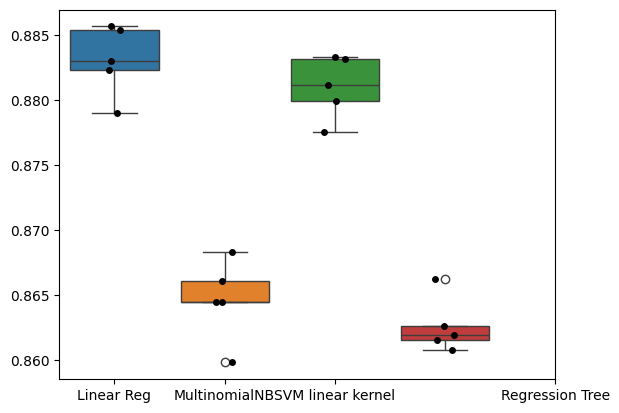

In [27]:
data=[scores_lr,scores_mnb,scores_svm,scores_rfc]
sns.boxplot(data)
sns.stripplot(data, color="black")
plt.xticks([0,1,2,4], ["Linear Reg","MultinomialNB","SVM linear kernel","Regression Tree"])
plt.show()

On va conserver le modèle de regression logistique qui a une moyenne quasi-équivalente et une meilleure variance. Elle a aussi comme atout d'avoir une meillure interprétabilité et simplicité.

In [28]:
lr=LogisticRegression()
model_final=lr.fit(X,Y)

# Inférence

## Mots avec le plus d'impacts

On va essayer de déterminer les mots qui ont le plus d'impact sur les prédictions positives ou négatives en utilisant les coefficients de notre modèle.

In [29]:
import numpy as np
nb_mots=10

list_coeff=lr.coef_[0,:]
index_sorted=np.argsort(list_coeff)
index_neg=index_sorted[:nb_mots]
index_pos=index_sorted[-nb_mots:]

In [30]:
mots_positifs={}
mots_negatifs={}
for keys,values in tfidf_vect.vocabulary_.items():
    if values in index_pos:
        mots_positifs[keys]=list_coeff[values]
    if values in index_neg:
        mots_negatifs[keys]=list_coeff[values]

In [31]:
mots_negatifs

{'annoying': -3.9844061595806344,
 'fix': -4.467917153523135,
 'ad': -3.8708323859910667,
 'worst': -4.812205946350479,
 'update': -3.6006041274891505,
 'stupid': -3.412567664254936,
 'crash': -3.821201171244772,
 'worse': -3.348870488554259,
 'missing': -4.4116019823714,
 'horrible': -3.276415152225147}

In [32]:
mots_positifs

{'great': 5.763085404441851,
 'best': 6.318463483684072,
 'love': 6.60684896747294,
 'wonderful': 4.886314932394541,
 'good': 5.762157915576045,
 'amazing': 5.840601302524887,
 'awesome': 4.820802572319387,
 'thank': 5.2625014606038185,
 'excellent': 5.2665368501904535,
 'fantastic': 4.459279819230405}

## Matrice de co-occurence

On va regarder les mots apparaissant le plus avec les mots que l'on a trouvé, c'est à dire extraire les éléments de la matrice de co-occurence qui correspondent aux mots positifs et négatifs trouvés avant. <br>On va regarder tout cela sur la colonne filtered car sinon cela demanderait trop de puissances de calculs.

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
df_tmp=df.copy()
df_tmp.loc[:,'filtered'] = df['filtered'].apply(lambda x: ' '.join(x))
vectorizer = CountVectorizer(ngram_range=(1, 1))
L=df_tmp.filtered.apply(len)
df_tmp=df_tmp[L>0]
tmp = vectorizer.fit_transform(df_tmp.filtered)

In [34]:
occ_df = pd.DataFrame(tmp.T.todense(), index=vectorizer.get_feature_names_out(), columns=range(len(df_tmp.lemmatize_j)))

In [35]:
def most_used_with(word):
    col_word=occ_df.loc[word]
    list_index_word=col_word[col_word>0].index.tolist() #liste des éléments (colonnes) où great apparait
    df_word=occ_df.iloc[:,list_index_word]
    ratio=df_word.sum(axis=1).sort_values(ascending=False)[1:]/compteur[word] # on enlève le premier car c'est le mot en paramètre
    return ratio

dic_most_used_with_pos={}
dic_most_used_with_neg={}
for word in mots_positifs:
    dic_most_used_with_pos[word]=most_used_with(word)
for word in mots_negatifs:
    dic_most_used_with_neg[word]=most_used_with(word)

## Trouver les mots les plus fréquents à côté de notre liste de mots

In [36]:

def is_next_to_word(word,text):
    L=[]
    n=len(text)
    if n==1:
        return[]
    for i in range(n):
        if text[i]==word:
            if i!=0 :
                L.append(text[i-1])
            if i!=(n-1):
                L.append(text[i+1])
    return [mot for mot in L if mot!=word]

def dic_next_to_word(word):
    List_next=df.filtered.apply(lambda x: is_next_to_word(word,x))
    List_next=List_next[List_next.apply(len)>0]
    D={}
    for list_word in List_next:
        for word in list_word:
            if word in D:
                D[word]=D[word]+1
            else:
                D[word]=1
    return D


In [37]:
dic_pos_most_next={}
dic_neg_most_next={}
for word in mots_positifs:
    dic_pos_most_next[word]=dic_next_to_word(word)
for word in mots_negatifs:
    dic_neg_most_next[word]=dic_next_to_word(word)

## Exemples sur 2 mots


Je choisis d'effectuer sur les mots "great" et "fix".
Trions le dictionnaire par valeur (nombre d'occurences à côté de ce mot) pour obtenir les plus fréquents et je garde seulement les 10 plus fréquents

In [38]:
word='great'
sorted_most_next = dict(sorted(dic_pos_most_next[word].items(), key=lambda item:item[1],
reverse=True)[:10])

In [39]:
dic_next_word_with_ratio={}
for mot,frequencies in sorted_most_next.items():
    dic_next_word_with_ratio[mot]=[frequencies,dic_most_used_with_pos[word][mot]]

dic_next_word_with_ratio

{'work': [191, 0.0903954802259887],
 'love': [188, 0.14508474576271185],
 'selection': [183, 0.05288135593220339],
 'would': [114, 0.07932203389830508],
 'experience': [109, 0.04519774011299435],
 'really': [109, 0.07796610169491526],
 'easy': [101, 0.059887005649717516],
 'overall': [91, 0.030508474576271188],
 'service': [88, 0.05152542372881356],
 'listening': [86, 0.07615819209039548]}

Ici, on choisit d'afficher le ratio d'apparations avec le mot ("great" ici) pour nuancer les résultats: si on apparaît énormément de fois dans le même commentaire, forcément on a plus de chances d'apparaître proche du mot.
Les mots plus précédés/suivis de "great" sont ceux ci-dessus. On identifie certains points forts de la plateforme comme son service ou la qualité sonore offerte. On peut répéter cette opération pour identifier les forces de Spotify avec d'autres mots.

In [40]:
word_neg='fix'
sorted_most_next_neg = dict(sorted(dic_neg_most_next[word_neg].items(), key=lambda item:item[1],
reverse=True)[:10])
D={}
for mot,frequencies in sorted_most_next_neg.items():
    D[mot]=[frequencies,dic_most_used_with_neg[word_neg][mot]]

D

{'please': [1241, 0.4671941971645236],
 'issue': [205, 0.1763930102209034],
 'problem': [168, 0.1724365314869766],
 'bug': [163, 0.11341905703923508],
 'pls': [122, 0.04681833168480053],
 'asap': [97, 0.04286185295087372],
 'need': [83, 0.06660072535443455],
 'soon': [64, 0.036927134849983514],
 'hope': [63, 0.03791625453346521],
 'dont': [56, 0.1493570722057369]}

On peut soit supposer que la filtration était trop forte et donc que l'on a perdu de l'information intéréssante soit qu'il n'y a aucune information associé. <br>Il y a cependant d'autres mots correspondant aux commentaires négatifs que l'on pourrait analyser.